## GNN使ってみた

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# データセットの読み込み（Coraデータセット）
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# GCNモデルの定義
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1層目の畳み込みと活性化関数
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # ドロップアウト（過学習の防止）
        x = F.dropout(x, training=self.training)
        # 2層目の畳み込み
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), x  # xを返して埋め込みとして使用

# モデルの初期化
model = GCN()
data = dataset[0]
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# 学習ループ
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out, _ = model(data)
    # 交差エントロピー損失
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    # 10エポックごとに損失を表示
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.9450
Epoch 10, Loss: 0.7187
Epoch 20, Loss: 0.2074
Epoch 30, Loss: 0.1090
Epoch 40, Loss: 0.0478
Epoch 50, Loss: 0.0507
Epoch 60, Loss: 0.0355
Epoch 70, Loss: 0.0450
Epoch 80, Loss: 0.0483
Epoch 90, Loss: 0.0449
Epoch 100, Loss: 0.0351
Epoch 110, Loss: 0.0272
Epoch 120, Loss: 0.0279
Epoch 130, Loss: 0.0332
Epoch 140, Loss: 0.0377
Epoch 150, Loss: 0.0376
Epoch 160, Loss: 0.0263
Epoch 170, Loss: 0.0323
Epoch 180, Loss: 0.0325
Epoch 190, Loss: 0.0259


Accuracy: 0.8040


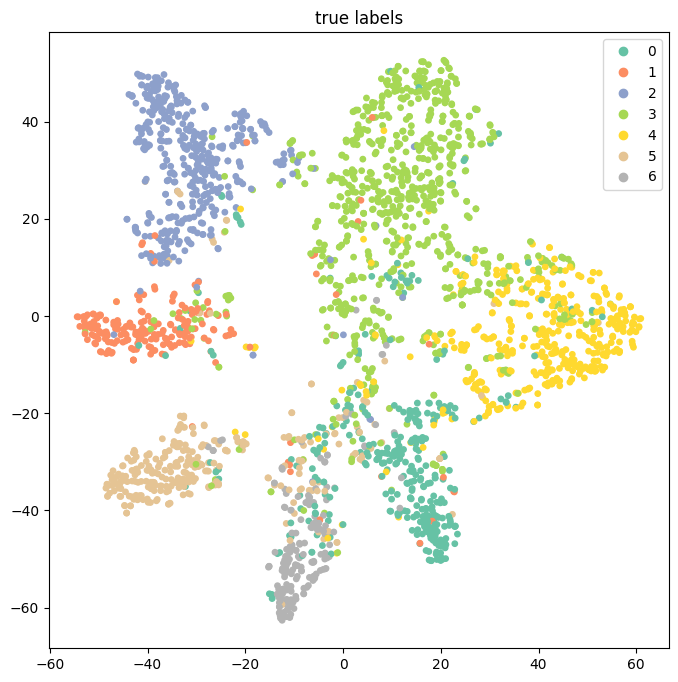

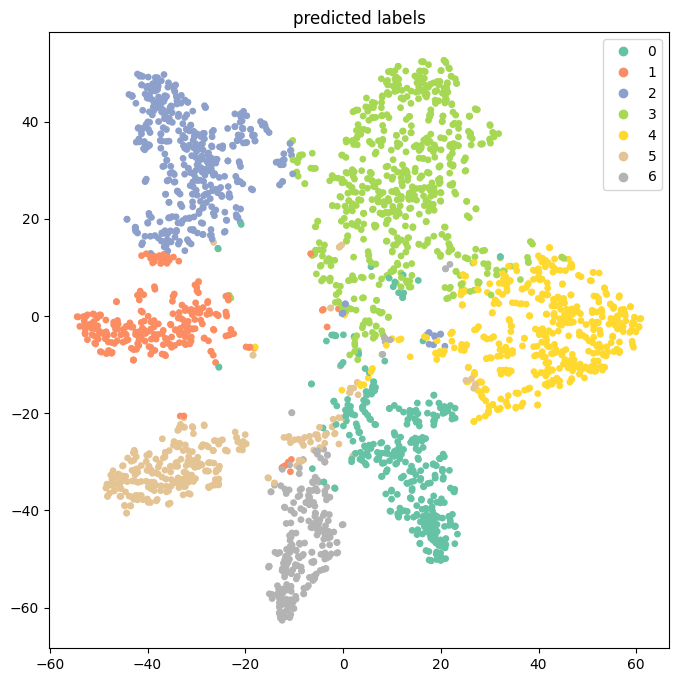

In [5]:
# モデルの評価
model.eval()
out, embeddings = model(data)
_, pred = out.max(dim=1)
# テストマスクを使って精度を計算
correct = int((pred[data.test_mask] == data.y[data.test_mask]).sum())
accuracy = correct / int(data.test_mask.sum())
print(f'Accuracy: {accuracy:.4f}')

# 埋め込みの可視化関数
def plot_embeddings(embeddings, labels, title):
    embeddings = embeddings.detach().numpy()
    labels = labels.numpy()
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="Set2", s=15)
    plt.legend(handles=scatter.legend_elements()[0], labels=list(range(dataset.num_classes)))
    plt.title(title)
    plt.show()

# ノード埋め込みを真のラベルで色付け
plot_embeddings(embeddings, data.y, "true labels")

# ノード埋め込みを予測ラベルで色付け
plot_embeddings(embeddings, pred, "predicted labels")
